# Image compression via QR factorization with pivot
This notebook shows an application of the QR factorization with pivoting in the field of image compression. So, we will use the so called "rank-revealing" algorithm.

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import linalg

### Load the image and convert from RGB to Gray scale

In [2]:
Imm = mpimg.imread('SatStorm.jpg')

#Y = 0.2125 R + 0.7154 G + 0.0721 B 
Imm_gray = 0.2125*Imm[:,:,0] + 0.7154*Imm[:,:,1] + 0.0721*Imm[:,:,2]

Original image size:  (1001, 1001, 3)
Gray image size:  (1001, 1001)


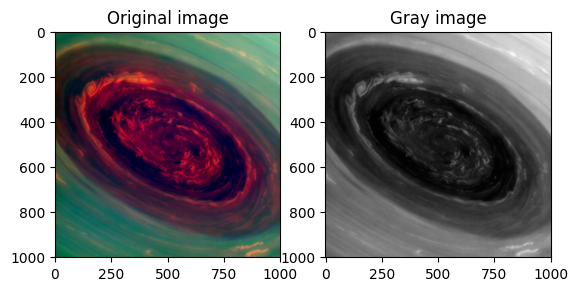

In [3]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(Imm)
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(Imm_gray, cmap = plt.cm.gray)
plt.title('Gray image')

print('Original image size: ', Imm.shape)
print('Gray image size: ', Imm_gray.shape)

# Low rank approximation via partial pivoting QR factorization

$Theorem$ 

For every matrix $A\in \mathbb{C}^{m\times n}$ there exist a unitary matrix $Q$ and a upper 'trapezoidal' matrix $R$ such that 

$$
A = QR.
$$

If $A$ is a square matrix ($m=n$), then $R$ is a upper triangular matrix and $Q$ can be an orthogonal matrix. 

$Proposition$

Given a matrix $A$ with rank $r$. Then, in exact arithmetic, the $QR$ factorization with partial pivot is given by 

$$
AP = Q \left(\begin{array}{cc}
R_{11} & R_{12}\\
0 & 0\\
\end{array}\right)\,, \quad R_{11} \mbox{ matrix } r\times r
$$

and the diagonal elements of $R_{11}$ are not all equal to zero ($R$ is not singular).

$\mathbf{N.B.}$ : The diagonal elements of  $R_{11}$ are not decreasing:
$$
|r_{11}|\geq |r_{22}|\geq \ldots
$$

When we apply the pivoting to the QR factorization, we construct a ''rank-revealing'' algorithm. Hence, beside improving the numerical stability, we can find the effective rank of the original matrix. 

In [4]:
# We perform the QR factorization with pivoting
[Q,R,P]=linalg.qr(Imm_gray, pivoting=True) # Imm_gray*P = Q*R

$\mathbf{N.B.}$ the output $P$ is an array which contains the indices of the permuted columns of the original matrix ``Imm_gray``. In order to apply the formula 

$$
Imm\_gray\, P = QR
$$
we need to write 

``Imm_gray[:,P] = Q*R``

which means that we are reordering the columns of Imm_gray according to the computed permutation.

Let us compute an approximation of the original image stored in ``Imm_gray`` by using only $k$ columns of $Q$ e $k$ rows of $R$. The number $k$ is chosen according to the level of accuracy we would like to reach:
1) Extract the modulus of the diagonal element of  $R$ and scale them with respect to their maximum, 

2) Store the tolerance values $\varepsilon_1, \varepsilon_2, \varepsilon_3$,

3) Choose $k$ as the number of diagonal elements of $R$ bigger than the different tolerances.

In [5]:
R_diag = np.diag(R) # We select the diagonal element of R
R_diag = abs(R_diag)/abs(np.max(R_diag)) # We compute the modulus of each diagonal element and we scaled wrt their maximum
tol = np.array([5e-1, 5e-2, 5e-3]) # array of tolerances

In [6]:
# We choose k to be the number of diagonal elements bigger than the threshold
k = np.zeros([1,len(tol)])

for i in range(len(tol)):
    k[0,i] = int(np.count_nonzero(R_diag>tol[i]))  # from the condition we have an array of True/ False, we use count_nonzero to find the number of True 
k = k.astype(int)[0] 
print('Array of k: ', k)

Array of k:  [ 14 368 928]


In [7]:
def compute_QR_PT(Q,R,R_diag_len,P,k):
    temp = np.dot(Q[:,0:k], R[0:k,:]) # we select only k columns of Q and k rows of R, and compute Q*R
    Perm = np.identity(R_diag_len) # We compute the permutation matrix according to the permutation used in the QR
    Perm = Perm[:,P]
    
    # reconstruct the original matrix computing Q*R*P.T
    # remember that we compute AP = QR -> A = QRP.T
    qr_app = np.dot(temp,Perm.T)
    return qr_app

Approximation with k= 14 (1001, 1001)
Approximation with k= 368 (1001, 1001)
Approximation with k= 928 (1001, 1001)


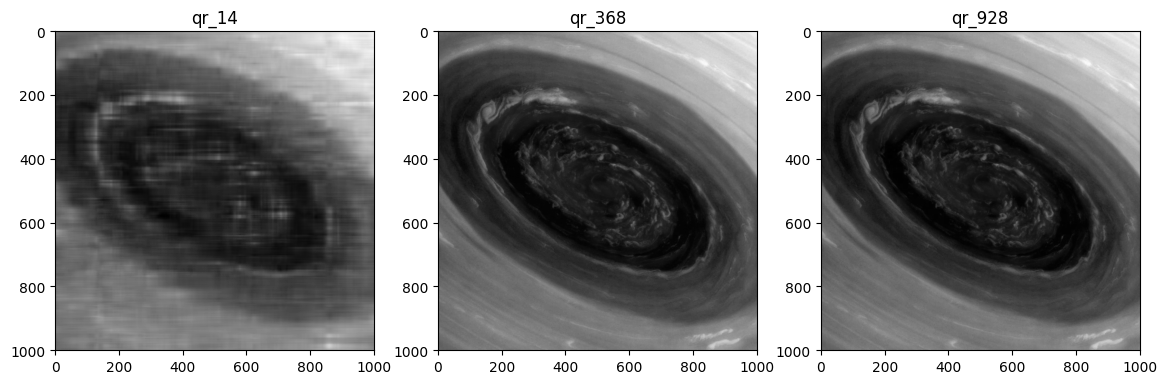

In [8]:
plt.figure(figsize=(14,8))

for i in range(len(k)):
    qr_app = compute_QR_PT(Q,R,len(R_diag),P,k[i])
    
    plt.subplot(1, len(k), i+1)
    plt.imshow(qr_app, cmap = plt.cm.gray)
    plt.title('qr_' + str(k[i]))
    
    #A_qr_14 = np.reshape(qr_app,[1001,1001])
    print('Approximation with k= '+ str(k[i]), qr_app.shape)

#### Let us compute the "cosine-similarity" between the original image and the reconstructed images

Also using k very small the cosine of the angle between each column of the original matrix and each column of the reconstructed matrix will be high. This means that the vector are quite parallel. Probably computing the cosine is not the correct choose.


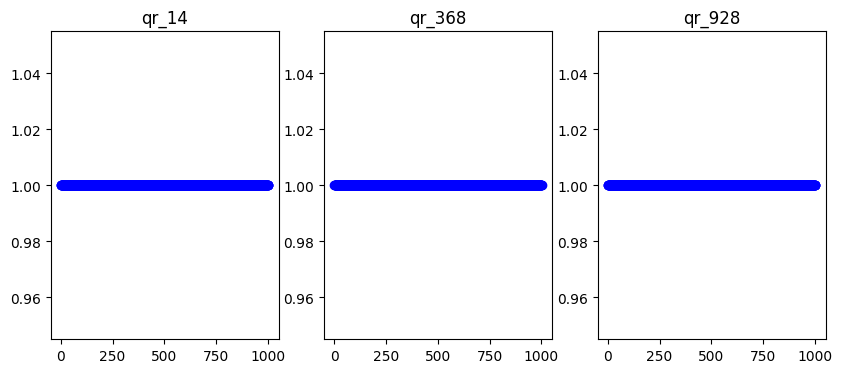

In [9]:
m,n = Imm_gray.shape
print('Also using k very small the cosine of the angle between each column of the original matrix and each column of the reconstructed matrix will be high.'
      ' This means that the vector are quite parallel. Probably computing the cosine is not the correct choose.')

plt.figure(figsize=(10,4))
for i in range(len(k)):
    cos_theta = np.zeros([1,n])
    qr_app = compute_QR_PT(Q,R,len(R_diag),P,k[i])
    
    for j in range(n):
        col = Imm_gray[:,j] 
        cos_theta[0,:] = np.dot(col,qr_app[:,j])/(np.linalg.norm(col)*np.linalg.norm(qr_app[:,j]))
        
    plt.subplot(1, len(k), i+1)
    plt.plot(np.linspace(1,n,n), cos_theta[0,:],'ob-')
    plt.title('qr_' + str(k[i]))